# Exploratory Analysis

This notebook contains steps and decisions made in the second iteration of exploring the Austin crime data.

## The Required Imports

Here we'll import all the modules required to run the code cells in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from wrangle import *
from prepare import split_data
from explore import *

## Acquire and Prepare Data

Here we'll acquire and prepare the data using the wrangle module.

In [2]:
# We'll need to explictly drop all cleared by exception rows.

df = wrangle_crime_data(drop_cleared_by_exception = True)
df.shape

Using cached csv


(348063, 19)

## Split the Data

Now we will need to split the data before we begin exploring because we will now begin exploring the relationship between the target variable and other features in the data.

In [3]:
train, validate, test = split_data(df, 'cleared')
train.shape, validate.shape, test.shape

((194915, 19), (83535, 19), (69613, 19))

From here on we'll only use the train variable.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194915 entries, 78606 to 205420
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   crime_type         194915 non-null  object         
 1   family_violence    194915 non-null  object         
 2   occurrence_time    194915 non-null  datetime64[ns] 
 3   occurrence_date    194915 non-null  datetime64[ns] 
 4   report_time        194915 non-null  datetime64[ns] 
 5   report_date        194915 non-null  datetime64[ns] 
 6   location_type      194915 non-null  object         
 7   address            194915 non-null  object         
 8   zip_code           194915 non-null  float64        
 9   council_district   194915 non-null  float64        
 10  sector             194915 non-null  object         
 11  district           194915 non-null  object         
 12  latitude           194915 non-null  float64        
 13  longitude          194915

## At what response time does clearance rate drop off significantly?

In [5]:
# Here we'll look at the difference in clearance rate between observations with time_to_report less than n hours and 
# observations with time_to_report greater than n hours where n is in the range 0 - 24 hours.

for hour in range(25):
    print(
        f'{hour}: ',
        train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean(),
        train[train.time_to_report > pd.Timedelta(f'{hour}h')].cleared.mean(),
        train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean() - \
        train[train.time_to_report > pd.Timedelta(f'{hour}h')].cleared.mean()
    )

0:  0.35153721682847894 0.10494181173294276 0.24659540509553618
1:  0.333593991151353 0.0833870555129189 0.2502069356384341
2:  0.3302386523163313 0.060012490773860214 0.2702261615424711
3:  0.32788399207906727 0.044312410390999 0.2835715816880683
4:  0.3245330675784807 0.03561012264859839 0.28892294492988235
5:  0.3211445671727106 0.03116400932155412 0.2899805578511565
6:  0.3177553856845031 0.029200826591391022 0.2885545590931121
7:  0.31464133746049117 0.028230813809090156 0.286410523651401
8:  0.31182092108345655 0.02771138542867587 0.2841095356547807
9:  0.30853211814561504 0.027452163420099984 0.28107995472551506
10:  0.30532557442714986 0.027154039328565343 0.2781715350985845
11:  0.30171467710676453 0.02719910891685231 0.27451556818991224
12:  0.29799805099637056 0.026860911567996037 0.27113713942837453
13:  0.2937920932620579 0.026572329560916264 0.26721976370114164
14:  0.2896892046552416 0.026359825703729477 0.26332937895151215
15:  0.28545735028550123 0.02626509339846572 0.

In [6]:
# Now let's put these results in a line chart.

clearance_rates = [train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean() for hour in range(7 * 24 + 1)]

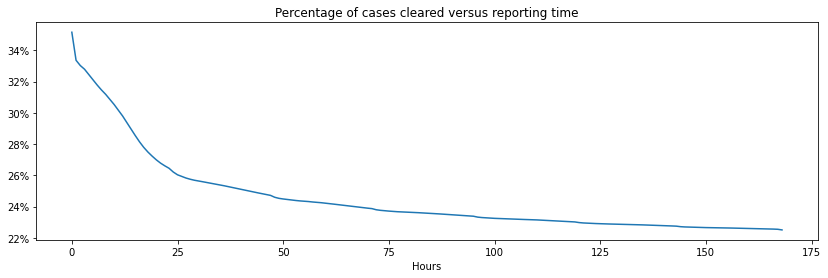

In [7]:
plt.figure(figsize = (14, 4))
temp = pd.DataFrame({'clearance_rate' : clearance_rates})

ax = sns.lineplot(data = temp, y = 'clearance_rate', x = temp.index)

plt.xlabel('Hours')
plt.ylabel('')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

plt.title('Percentage of cases cleared versus reporting time');

In [8]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('5h'),
        pd.Timedelta('10y')
    ],
    labels = [
        'Less than 5 hours',
        'Greater than 5 hours'
    ]
)

/usr/local/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


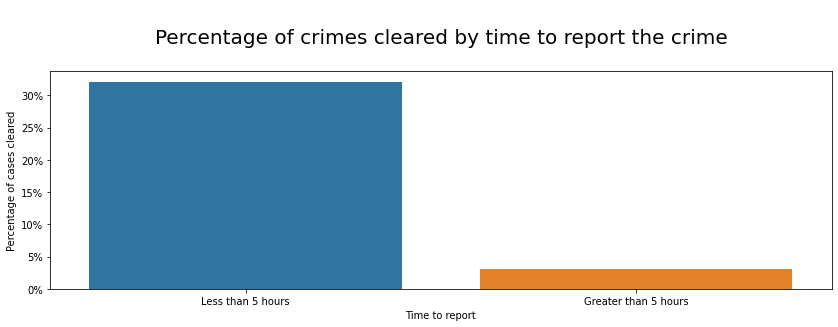

In [9]:
plt.figure(figsize = (14, 4))

ax = sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None
)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

title = '''
Percentage of crimes cleared by time to report the crime
'''
plt.title(title, fontsize = 20);

In [10]:
train.time_to_report_bins.value_counts(normalize = True)

Less than 5 hours       0.610328
Greater than 5 hours    0.389672
Name: time_to_report_bins, dtype: float64

## How does type of crime affect the dependency between clearance status and time to report?

I'm interested to know for which crime types is there no significant difference in clearance rate between crimes with a report time less than 24 hours and crimes with a report time greater than 24 hours.

In [11]:
# Here we're going to run a t-test for each crime type testing the following hypothesis:
# H0: The average number of cases cleared for cases with time to report less than 24 hours is equal 
# to the average number of cases cleared for cases with time to report greater than 24 hours.

# We'll keep a list of all crime types where p is not less than alpha meaning the null hypothesis could not 
# be rejected.
# We'll only look at crime types with at least 30 observations and assume non equal variance for simplicity.

alpha = 0.05
types = []

time_to_report_less_than_5hrs = train.time_to_report <= pd.Timedelta('5h')
time_to_report_greater_than_5hrs = train.time_to_report > pd.Timedelta('5h')

for crime in train.crime_type.unique():
    subset = train[train.crime_type == crime]
    
    if train[train.crime_type == crime].cleared.count() > 100 and train[train.crime_type == crime].cleared.mean() < 0.5:
        t, p = stats.ttest_ind(
            subset[time_to_report_less_than_5hrs].cleared,
            subset[time_to_report_greater_than_5hrs].cleared,
            alternative = 'greater',
            equal_var = False
        )
        if p >= alpha:
            types.append(crime)

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_6945/3870558388.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_less_than_5hrs].cleared,
/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_6945/3870558388.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_greater_than_5hrs].cleared,


In [12]:
len(types)

23

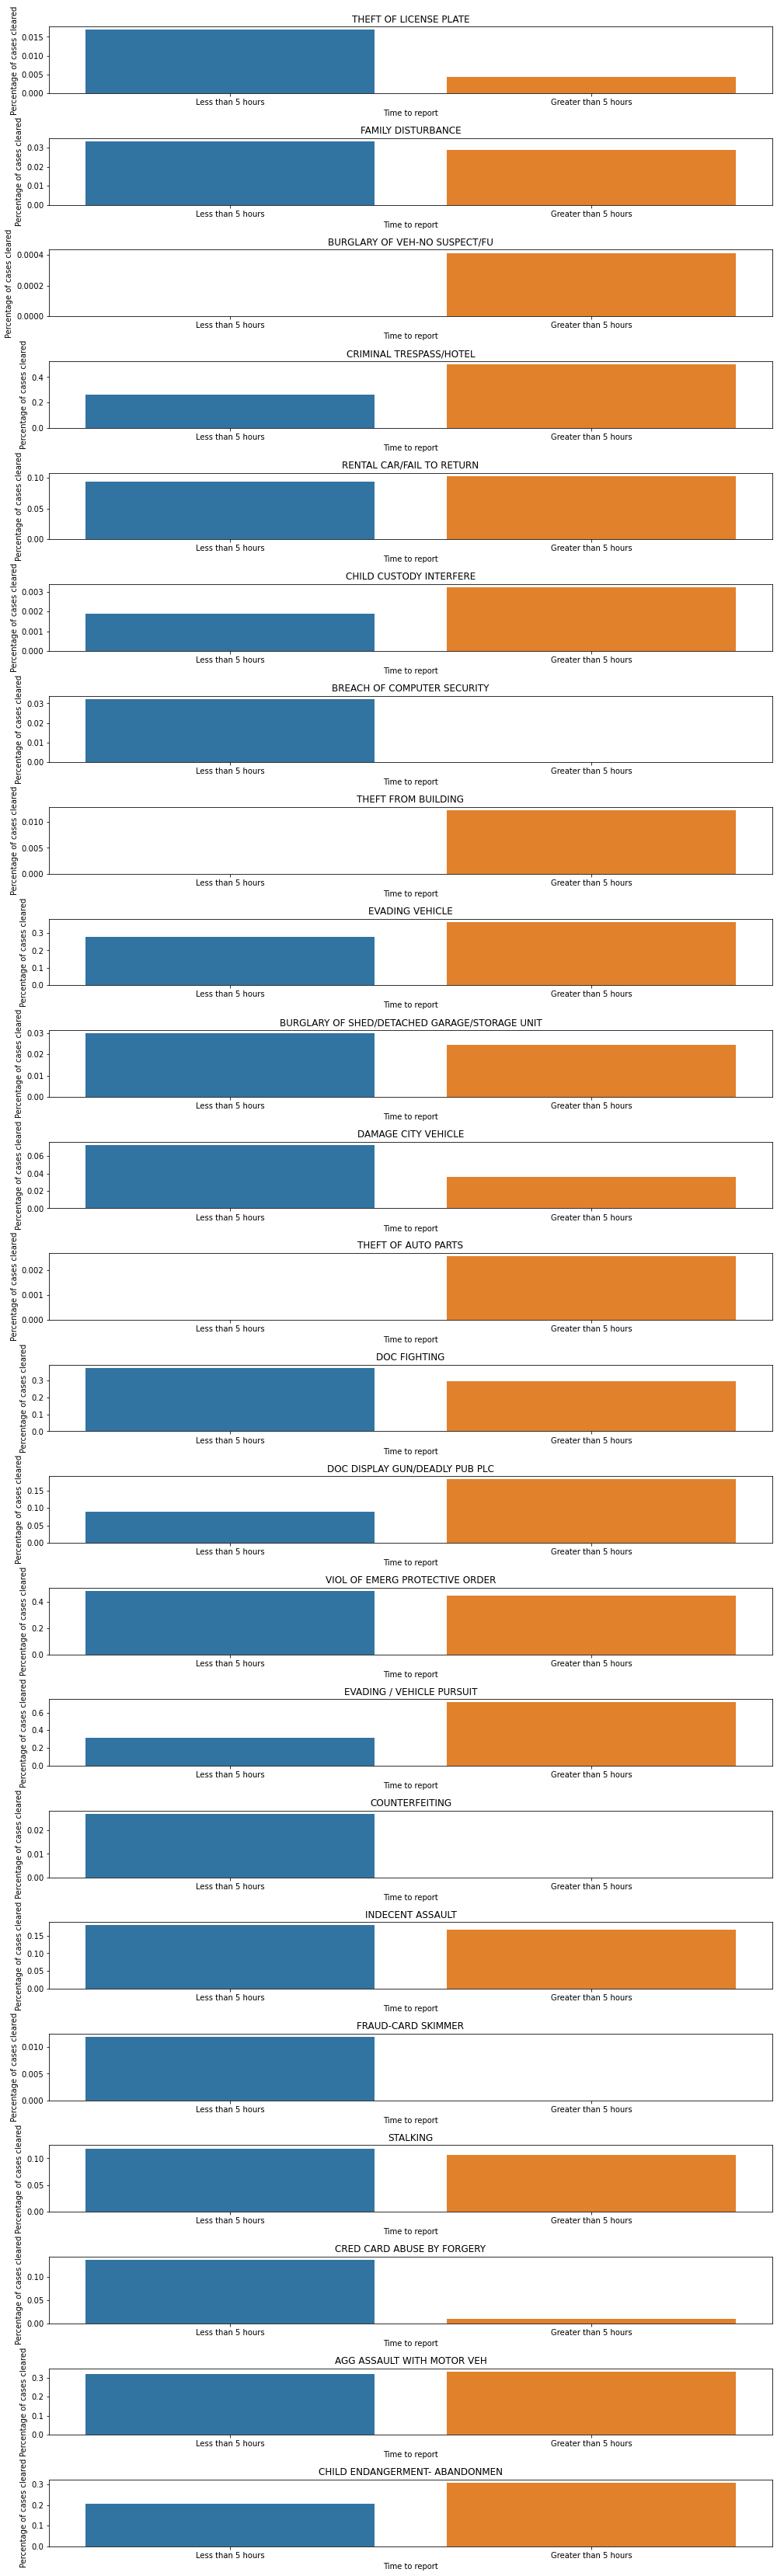

In [13]:
fig, ax = plt.subplots(nrows = len(types), ncols = 1, figsize = (14, 2 * len(types)))

for index, crime_type in enumerate(types):
    sns.barplot(
        data = train[train.crime_type == crime_type],
        x = 'time_to_report_bins',
        y = 'cleared',
        ci = None,
        ax = ax[index]
    )

    ax[index].set_xlabel('Time to report')
    ax[index].set_ylabel('Percentage of cases cleared')

    ax[index].set_title(crime_type)
    
plt.tight_layout();

In [14]:
sorted(types)

['AGG ASSAULT WITH MOTOR VEH',
 'BREACH OF COMPUTER SECURITY',
 'BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT',
 'BURGLARY OF VEH-NO SUSPECT/FU',
 'CHILD CUSTODY INTERFERE',
 'CHILD ENDANGERMENT- ABANDONMEN',
 'COUNTERFEITING',
 'CRED CARD ABUSE BY FORGERY',
 'CRIMINAL TRESPASS/HOTEL',
 'DAMAGE CITY VEHICLE',
 'DOC DISPLAY GUN/DEADLY PUB PLC',
 'DOC FIGHTING',
 'EVADING / VEHICLE PURSUIT',
 'EVADING VEHICLE',
 'FAMILY DISTURBANCE',
 'FRAUD-CARD SKIMMER',
 'INDECENT ASSAULT',
 'RENTAL CAR/FAIL TO RETURN',
 'STALKING',
 'THEFT FROM BUILDING',
 'THEFT OF AUTO PARTS',
 'THEFT OF LICENSE PLATE',
 'VIOL OF EMERG PROTECTIVE ORDER']

### Takeaways

This list of crime types are all crimes with at least 100 observations where the reporting time does not make a significant difference in clearance rate. There are a few ways to interpret this. These can either be crimes that are generally unsolvable, or at least unclearable. Otherwise, we can look at these crimes as areas of improvement since reporting time doesn't seem to make a difference in the solvability of these crimes.

## Clearance Date

In [15]:
train[train.cleared == False].head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,pandemic_lockdown,time_to_report_bins
78606,BURGLARY OF VEHICLE,N,2021-07-15 15:23:00,2021-07-15,2021-07-15 17:06:00,2021-07-15,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,1400 RIDGEHAVEN DR,78723.0,4.0,ID,5,30.314104,-97.699438,not cleared,2021-07-16,False,0 days 01:43:00,False,Less than 5 hours
298887,THEFT OF LICENSE PLATE,N,2019-05-15 13:08:00,2019-05-15,2019-07-01 13:08:00,2019-07-01,OTHER / UNKNOWN,1300 E RIVERSIDE DR,78741.0,9.0,HE,2,30.248501,-97.733939,not cleared,2019-07-02,False,47 days 00:00:00,False,Greater than 5 hours
123957,IDENTITY THEFT,N,2021-01-22 16:16:00,2021-01-22,2021-02-11 16:16:00,2021-02-11,RESIDENCE / HOME,423 BALDRIDGE DR,78748.0,2.0,FR,3,30.178308,-97.792630,not cleared,2021-02-12,False,20 days 00:00:00,False,Greater than 5 hours
268120,BURGLARY OF VEHICLE,N,2019-08-25 16:00:00,2019-08-25,2019-08-25 18:31:00,2019-08-25,RESTAURANT,11680 RESEARCH BLVD SVRD SB,78759.0,10.0,AD,7,30.418011,-97.747577,not cleared,2019-09-06,False,0 days 02:31:00,False,Less than 5 hours
133083,AUTO THEFT,N,2020-12-18 11:47:00,2020-12-18,2020-12-18 11:47:00,2020-12-18,PARKING /DROP LOT/ GARAGE,12518 RESEARCH BLVD SVRD SB,78759.0,10.0,AD,7,30.428713,-97.760471,not cleared,2021-01-11,False,0 days 00:00:00,False,Less than 5 hours


Even for crimes that are not cleared there is a clearance date. This would definitely require more context to understand.

## Multivariate Analysis With Crime Types

Let's look at how the crime types vary with different variables.

In [16]:
# We'll use the merged dataframe for this analysis.

df = wrangle_merged_df(drop_columns = True)
train, validate, test = split_data(df)

Using cached csv


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197671 entries, 162671 to 100340
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   crime_type         197671 non-null  object         
 1   family_violence    197671 non-null  object         
 2   occurrence_time    197671 non-null  datetime64[ns] 
 3   occurrence_date    197671 non-null  datetime64[ns] 
 4   report_time        197671 non-null  datetime64[ns] 
 5   report_date        197671 non-null  datetime64[ns] 
 6   location_type      197671 non-null  object         
 7   address            197671 non-null  object         
 8   zip_code           197671 non-null  float64        
 9   council_district   197671 non-null  float64        
 10  sector             197671 non-null  object         
 11  latitude           197671 non-null  float64        
 12  longitude          197671 non-null  float64        
 13  clearance_status   19767

In [18]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('24h'),
        pd.Timedelta('10y')
    ],
    labels = [
        'Less than 24 hours',
        'Greater than 24 hours'
    ]
)

/usr/local/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


### pd_district

In [19]:
train.district_name.value_counts()

EDWARD 1    8219
HENRY 2     7239
GEORGE 2    6043
EDWARD 2    5622
DAVID 1     5427
            ... 
EDWARD 5    1065
HENRY 6      883
GEORGE 4     738
DAVID 8      734
EDWARD 8     120
Name: district_name, Length: 68, dtype: int64

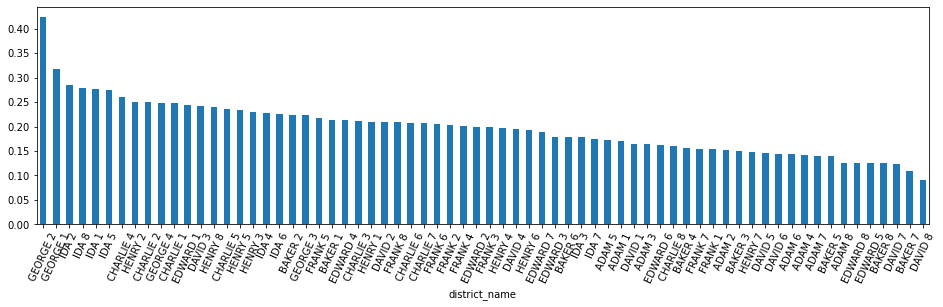

In [20]:
train.groupby('district_name').cleared.mean().sort_values(ascending = False).plot.bar(figsize = (16, 4))

plt.xticks(rotation = 65);

In [21]:
train[train.patrol_area == 'DTAC'].district_name.unique()

array(['GEORGE 2', 'GEORGE 3', 'GEORGE 1', 'GEORGE 4'], dtype=object)

### patrol_area

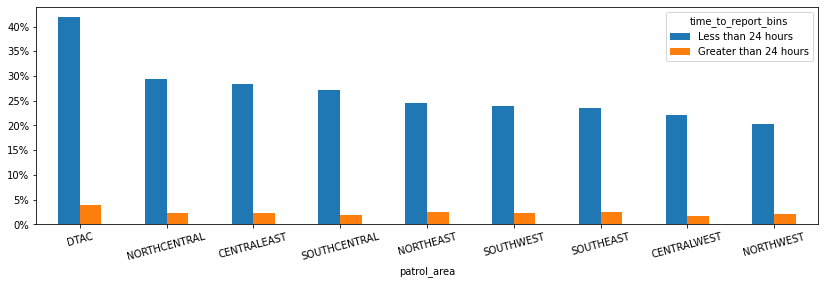

In [22]:
ax = (
    train.groupby(['patrol_area', 'time_to_report_bins'])
    .cleared
    .mean()
    .unstack()
    .sort_values(by = 'Less than 24 hours', ascending = False)
    .plot.bar(figsize = (14, 4))
)

plt.xticks(rotation = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0));

In [23]:
# Due to the large number of crime type categories, for exploration purposes we'll use only the top
# 10 crime categories.

top_10_crimes = [
    'DWI',
    'ASSAULT WITH INJURY',
    'THEFT BY SHOPLIFTING',
    'HARASSMENT',
    'AUTO THEFT',
    'ASSAULT W/INJURY-FAM/DATE VIOL',
    'CRIMINAL MISCHIEF',
    'FAMILY DISTURBANCE',
    'THEFT',
    'BURGLARY OF VEHICLE'
]

# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

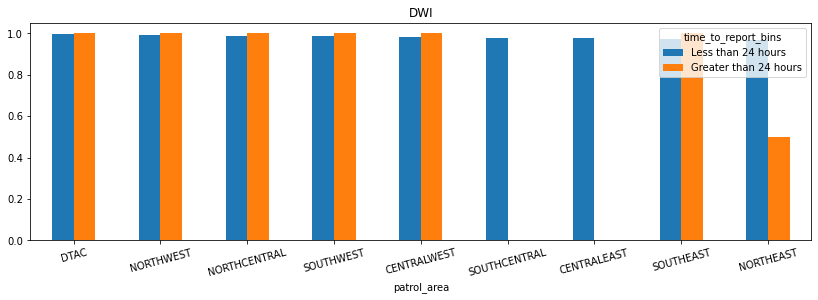

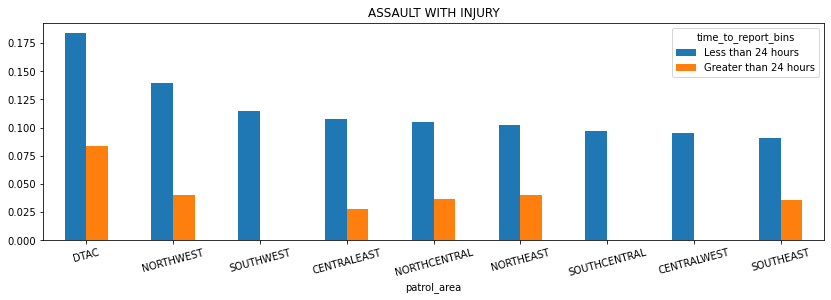

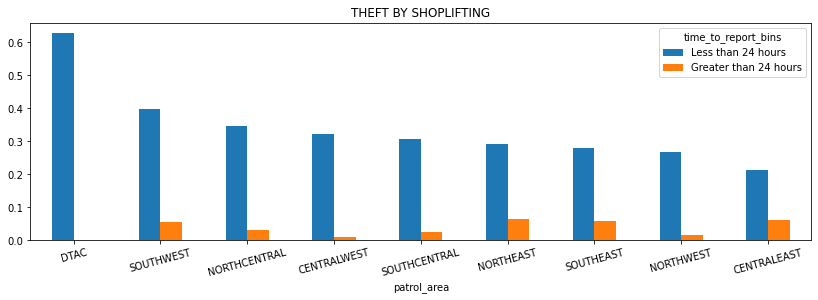

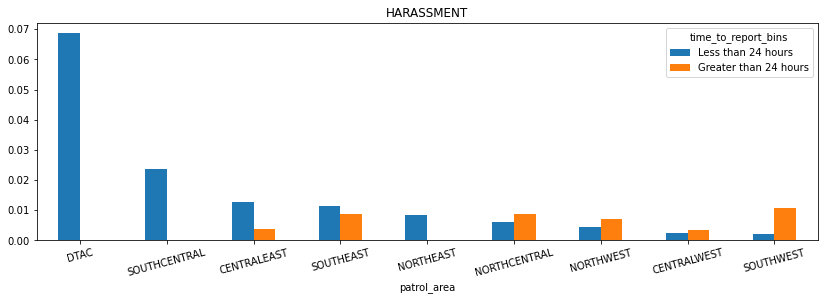

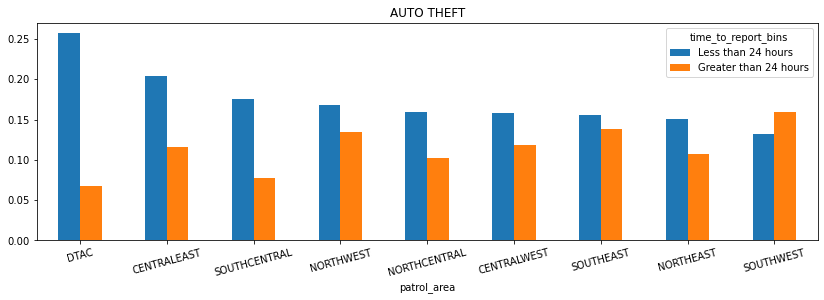

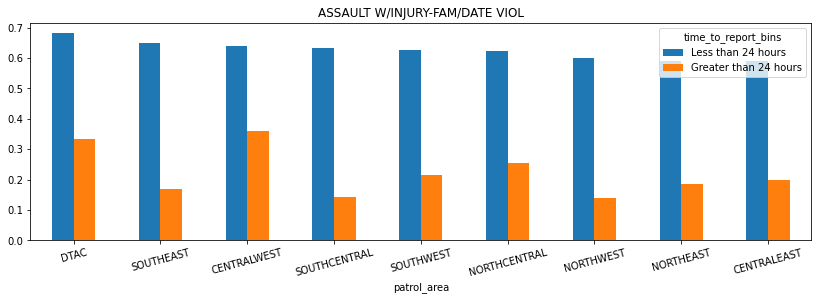

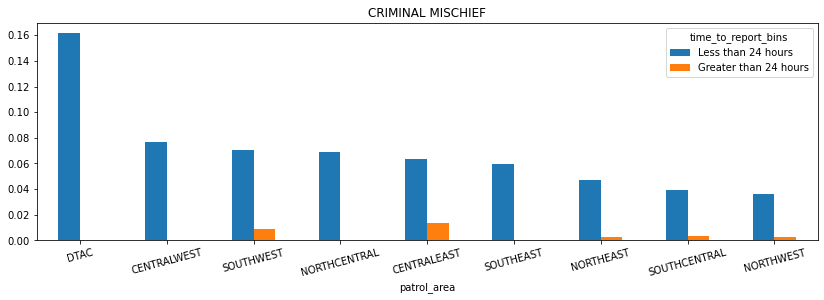

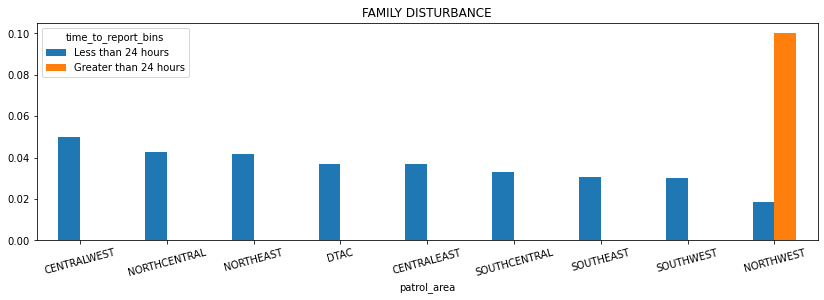

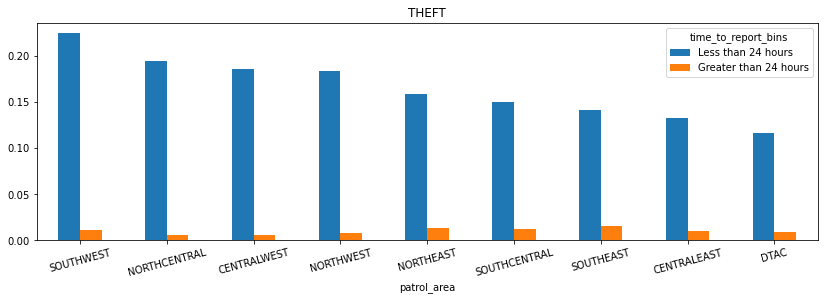

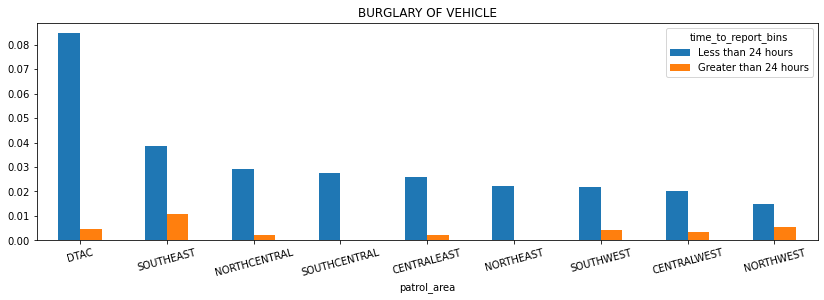

In [24]:
for crime in top_10_crimes:
    (
        train[train.crime_type == crime].groupby(['patrol_area', 'time_to_report_bins'])
        .cleared
        .mean()
        .unstack()
        .sort_values(by = 'Less than 24 hours', ascending = False)
        .plot.bar(figsize = (14, 4))
    )
    
    plt.title(crime)

    plt.xticks(rotation = 15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))
    
    plt.show()

In [25]:
train.groupby('patrol_area').time_to_report.mean().sort_values()

patrol_area
DTAC           3 days 12:57:45.388704318
SOUTHCENTRAL   4 days 08:02:12.146165723
NORTHEAST      4 days 08:42:42.703303002
NORTHCENTRAL   4 days 18:49:44.742288757
CENTRALEAST    4 days 21:11:55.329068941
SOUTHEAST      5 days 11:45:27.579505300
CENTRALWEST    5 days 19:16:20.204752154
SOUTHWEST      5 days 23:10:42.508749602
NORTHWEST      6 days 06:41:57.949985089
Name: time_to_report, dtype: timedelta64[ns]

In [26]:
train[train.time_to_report <= pd.Timedelta('1d')].groupby('patrol_area').time_to_report.mean().sort_values()

patrol_area
DTAC           0 days 02:44:45.272016831
CENTRALEAST    0 days 02:50:36.471702581
SOUTHCENTRAL   0 days 02:59:42.738357415
NORTHCENTRAL   0 days 02:59:49.577781947
SOUTHEAST      0 days 03:00:27.368477560
NORTHEAST      0 days 03:03:18.581365468
SOUTHWEST      0 days 03:57:18.916671167
NORTHWEST      0 days 04:07:56.238387379
CENTRALWEST    0 days 04:47:51.317942917
Name: time_to_report, dtype: timedelta64[ns]

## Location Type Analysis

Let's do some analysis on location types. We're interested in knowing which types of locations typically see higher levels of crime and what the clearance rate for those location types are.

In [27]:
train.location_type.value_counts(normalize = True)

RESIDENCE / HOME                                   0.406195
HWY / ROAD / ALLEY/ STREET/ SIDEWALK               0.167936
PARKING /DROP LOT/ GARAGE                          0.127328
OTHER / UNKNOWN                                    0.073597
COMMERCIAL / OFFICE BUILDING                       0.027202
HOTEL / MOTEL / ETC.                               0.022269
DEPARTMENT / DISCOUNT STORE                        0.022107
RESTAURANT                                         0.019978
GROCERY / SUPERMARKET                              0.016826
CONVENIENCE STORE                                  0.015971
SERVICE/ GAS STATION                               0.014610
DRUG STORE / DOCTOR'S OFFICE / HOSPITAL            0.011721
BAR / NIGHTCLUB                                    0.011135
PARK / PLAYGROUND                                  0.008803
SPECIALTY  STORE                                   0.008292
CONSTRUCTION SITE                                  0.004745
GOVERNMENT / PUBLIC BUILDING            

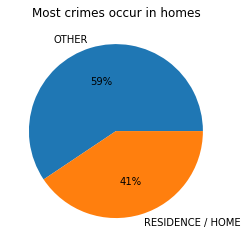

In [36]:
train['location_bins'] = np.where(train.location_type == 'RESIDENCE / HOME', 'RESIDENCE / HOME', 'OTHER')

train.location_bins.value_counts().plot(figsize = (14, 4), kind = 'pie', y='cleared', autopct="%1.0f%%")
plt.ylabel('')

plt.title('Most crimes occur in homes');

In [28]:
train.groupby('location_type').cleared.agg(['count', 'mean']).sort_values(by = 'count', ascending = False)

,count,mean
location_type,,
RESIDENCE / HOME,80293,0.116735
HWY / ROAD / ALLEY/ STREET/ SIDEWALK,33196,0.501295
PARKING /DROP LOT/ GARAGE,25169,0.175772
OTHER / UNKNOWN,14548,0.082211
COMMERCIAL / OFFICE BUILDING,5377,0.051144
HOTEL / MOTEL / ETC.,4402,0.243299
DEPARTMENT / DISCOUNT STORE,4370,0.346224
RESTAURANT,3949,0.176754
GROCERY / SUPERMARKET,3326,0.349369


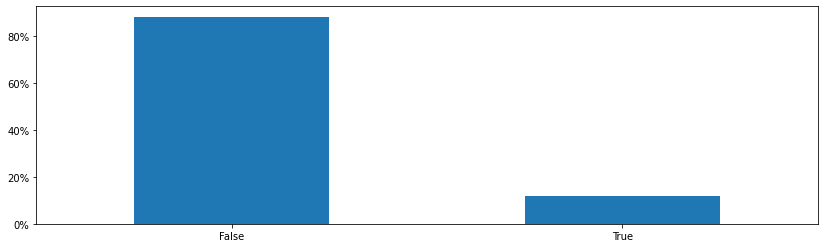

In [41]:
train[train.location_type == 'RESIDENCE / HOME'].cleared.value_counts(normalize = True).plot.bar(figsize = (14, 4))

plt.xticks(rotation = 0)
plt.gca().yaxis.set_major_formatter('{:.0%}'.format);

In [29]:
train[train.location_type == 'RESIDENCE / HOME'].crime_type.value_counts(normalize = True)

FAMILY DISTURBANCE                0.146513
BURGLARY OF VEHICLE               0.083830
THEFT                             0.073556
ASSAULT W/INJURY-FAM/DATE VIOL    0.067590
HARASSMENT                        0.055982
                                    ...   
ILLUMIN AIRCRAFT INTENSE LIGHT    0.000012
TRUANCY                           0.000012
DOC CREATING NOXIOUS ODOR         0.000012
TAMPERING WITH CONSUMER PROD      0.000012
FAIL TO REGISTER- MINOR VIC       0.000012
Name: crime_type, Length: 251, dtype: float64

## Investigating Pandemic Stay at Home Order Effects

We are interested in seeing how the COVID-19 pandemic affected crime clearance rates in the city of Austin. Here we'll use the pandemic_lockdown feature to investigate this relationship.

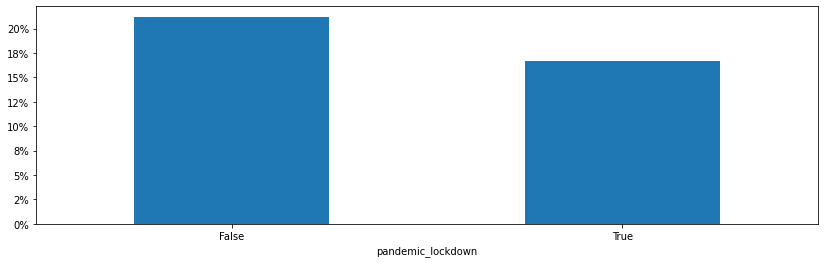

In [30]:
ax = train.groupby('pandemic_lockdown').cleared.mean().plot.bar(figsize = (14, 4))

plt.xticks(rotation = 0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0));

It looks like there was a lower clearance rate during the peak of stay at home orders. Let's see if this is a significant difference. We'll test the following hypothesis:

$H_0$: There is no difference in average cleared cases for crimes occurring during active COVID-19 stay at home orders and average cleared cases for crimes occurring outside of active COVID-19 stay at home orders.
<br>
$H_a$: The average cleared cases for crimes occurring during active COVID-19 stay at home orders is less than the average cleared cases for crimes occurring outside of active COVID-19 stay at home orders.

In [31]:
t_test_ind(
    train[train.pandemic_lockdown == True].cleared,
    train[train.pandemic_lockdown == False].cleared,
    alternative = 'less'
)

The t value between the two samples is -15.66 and the P-Value is 1.5511683921032692e-55.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


### What crime types are more prevalent when pandemic lockdown was in effect?

In [32]:
train[train.pandemic_lockdown == True].crime_type.value_counts().head(10)

BURGLARY OF VEHICLE               2534
THEFT                             1771
FAMILY DISTURBANCE                1595
CRIMINAL MISCHIEF                 1496
AUTO THEFT                         948
ASSAULT W/INJURY-FAM/DATE VIOL     875
HARASSMENT                         771
BURGLARY NON RESIDENCE             684
THEFT BY SHOPLIFTING               600
ASSAULT WITH INJURY                592
Name: crime_type, dtype: int64

In [33]:
train[train.pandemic_lockdown == False].crime_type.value_counts().head(10)

BURGLARY OF VEHICLE               17100
THEFT                             14988
FAMILY DISTURBANCE                12655
CRIMINAL MISCHIEF                  9397
AUTO THEFT                         6314
ASSAULT W/INJURY-FAM/DATE VIOL     6292
HARASSMENT                         5159
THEFT BY SHOPLIFTING               5115
ASSAULT WITH INJURY                4974
DWI                                4110
Name: crime_type, dtype: int64

Interestingly there is not much difference in the top crimes for pandemic lockdown times versus non lockdown times.

### Was crime overall less prevalent during stay at home times?

In [34]:
pd.to_datetime('2020-08-26') - pd.to_datetime('2020-03-14')

Timedelta('165 days 00:00:00')

In [35]:
len(train[train.pandemic_lockdown == True]) / 165

134.8181818181818

In [36]:
4 * 365 + 1

1461

In [37]:
len(train[train.pandemic_lockdown == False]) / 1461

120.072553045859